In [ ]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, SpatialDropout1D, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import gensim.downloader as api

In [ ]:
# Menetapkan seed untuk memastikan hasil yg dihasilkan oleh NumPy bersifat reproducible (tetap sama setiap kali dijalankan)
np.random.seed(42)

# Menetapkan seed untuk TensorFlow agar proses pelatihan model dan operasi acak lainnya dapat direproduksi
tf.random.set_seed(42)

In [ ]:
# Mengunduh daftar stopwords (kata-kata umum yg biasanya diabaikan dalam pemrosesan teks)
nltk.download('stopwords')

# Mengunduh WordNet, yaitu kamus leksikal bahasa Inggris yg digunakan untuk proses lemmatization
nltk.download('wordnet')

# Menginisialisasi daftar stopwords dalam bahasa Inggris
stop_words = set(stopwords.words('english'))

# Membuat objek lemmatizer untuk mengubah kata ke bentuk dasarnya (lemma)
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Load Dataset
from google.colab import drive
drive.mount("/content/drive")
file_path = "/content/drive/MyDrive/Colab Notebooks/training.1600000.processed.noemoticon.csv"
columns = ['target', 'ids', 'date', 'flag', 'user', 'text']
data = pd.read_csv(file_path, encoding='ISO-8859-1', names=columns)

Mounted at /content/drive


In [ ]:
# Hanya menggunakan 2 label/kolom
data = data[['target', 'text']]

In [ ]:
print("Unique labels before mapping:", data['target'].unique()) # Menampilkan label unik pada kolom target
data['target'] = data['target'].map({0: 0, 4: 1}) # Melakukan pemetaan nilai label: 0 tetap 0, dan 4 diubah menjadi 1
print("Unique labels after mapping:", data['target'].unique()) # Menampilkan label unik pada kolom 'target' setelah pemetaan
data.dropna(subset=['target'], inplace=True) # Menghapus baris yg memiliki nilai NaN pada kolom target

Unique labels before mapping: [0 4]
Unique labels after mapping: [0 1]


In [ ]:
duplicates_raw = data.duplicated(subset='text').sum() # Menghitung jumlah data duplikat berdasarkan kolom 'text'
print(f"Total duplicates found in raw text: {duplicates_raw}")
data.drop_duplicates(subset='text', inplace=True) # Menghapus data duplikat berdasarkan kolom 'text'
print(f"Duplicates removed. Current size: {data.shape}") # Menampilkan ukuran data setelah duplikat dihapus

Total duplicates found in raw text: 18534
Duplicates removed. Current size: (1581466, 2)


In [ ]:
data.head() # Menampilkan dataset (head: 5 data teratas)

,target,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


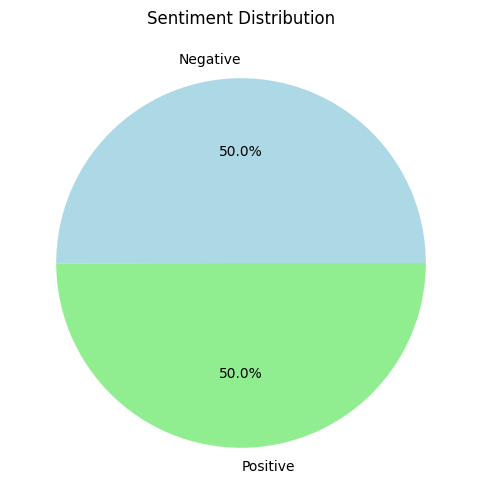

In [ ]:
# Menampilkan ebelum Cleansing
plt.figure(figsize=(6,6))
label_counts = data['target'].value_counts() # Menghitung jumlah masing-masing label sentimen dalam kolom 'target'
plt.pie(label_counts, labels=['Negative', 'Positive'], autopct='%1.1f%%', colors=['lightblue', 'lightgreen']) # Membuat diagram pie untuk menunjukkan distribusi sentimen
plt.title('Sentiment Distribution')
plt.show()

In [ ]:
# Fungsi untuk membersihkan teks
def clean_text(text):
    text = text.lower()  # Mengubah semua huruf menjadi huruf kecil
    text = re.sub(r"http\S+", "", text)  # Menghapus URL
    text = re.sub(r"@\w+", "", text) # Menghapus mention (misalnya @username)
    text = re.sub(r"#", "", text)  # Menghapus tanda #
    text = re.sub(r"<.*?>", "", text)  # Menghapus tag HTML
    text = text.translate(str.maketrans("", "", string.punctuation))  # Menghapus tanda baca
    text = re.sub(r"\d+", "", text) # Menghapus angka
    text = re.sub(r"\s+", " ", text).strip() # Menghapus spasi berlebih dan strip di awal/akhir
    tokens = text.split() # Tokenisasi: memecah teks menjadi kata-kata
    tokens = [word for word in tokens if word not in stop_words]  # Menghapus stopwords (kata-kata umum yg tidak bermakna secara kontekstual)
    tokens = [lemmatizer.lemmatize(word) for word in tokens] # Melakukan lemmatization (mengubah kata ke bentuk dasar)
    return " ".join(tokens)  # Menggabungkan kembali token menjadi satu kalimat

data['clean_text'] = data['text'].apply(clean_text)  # Menyimpan di kolom baru 'clean_text'

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1581466 entries, 0 to 1599999
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   target      1581466 non-null  int64 
 1   text        1581466 non-null  object
 2   clean_text  1581466 non-null  object
dtypes: int64(1), object(2)
memory usage: 48.3+ MB


In [ ]:
data.head()

,target,text,clean_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",awww thats bummer shoulda got david carr third...
1,0,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...
2,0,@Kenichan I dived many times for the ball. Man...,dived many time ball managed save rest go bound
3,0,my whole body feels itchy and like its on fire,whole body feel itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",behaving im mad cant see


In [ ]:
# Menghitung jumlah data duplikat berdasarkan kolom 'clean_text' setelah proses pembersihan teks
duplicates_cleaned = data.duplicated(subset='clean_text').sum()
print(f"Total duplicates found in cleaned text: {duplicates_cleaned}")

Total duplicates found in cleaned text: 100780


In [ ]:
# Menghapus data duplikat berdasarkan kolom 'clean_text' setelah proses pembersihan teks
data.drop_duplicates(subset='clean_text', inplace=True)
print(f"Duplicates removed in cleaned text. Current size: {data.shape}")

Duplicates removed in cleaned text. Current size: (1480686, 3)


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1480686 entries, 0 to 1599999
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   target      1480686 non-null  int64 
 1   text        1480686 non-null  object
 2   clean_text  1480686 non-null  object
dtypes: int64(1), object(2)
memory usage: 45.2+ MB


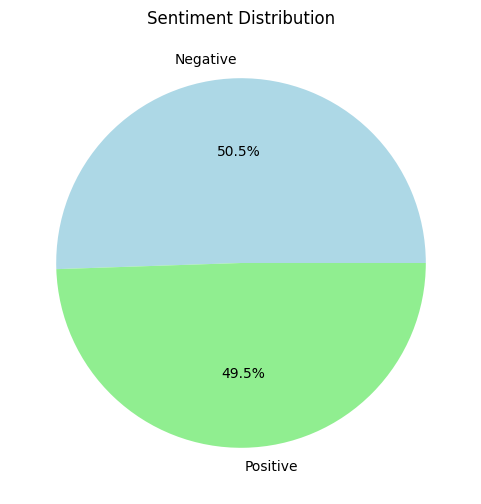

In [ ]:
# Menampilkan distribusi setelah cleansing
plt.figure(figsize=(6,6))
label_counts = data['target'].value_counts() # Menghitung jumlah masing-masing label dalam kolom target
plt.pie(label_counts, labels=['Negative', 'Positive'], autopct='%1.1f%%', colors=['lightblue', 'lightgreen'])
plt.title('Sentiment Distribution')
plt.show()

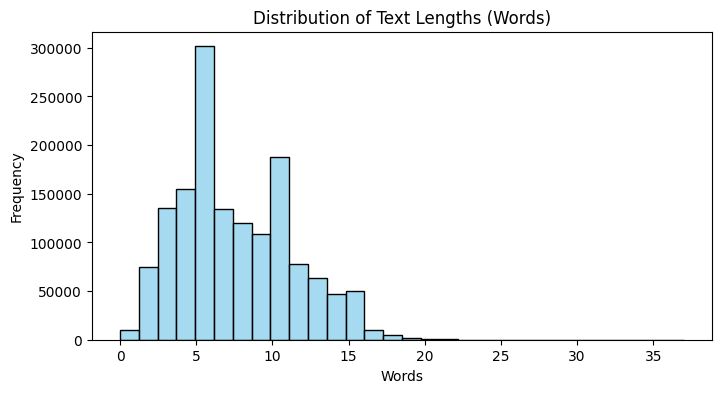

In [ ]:
text_lengths = data['clean_text'].apply(lambda x: len(x.split())) # Menghitung panjang setiap teks (jumlah kata) dalam kolom clean_text
plt.figure(figsize=(8,4))
sns.histplot(text_lengths, bins=30, color='skyblue') # Membuat histogram untuk memvisualisasikan distribusi panjang teks (dalam jumlah kata)
plt.title('Distribution of Text Lengths (Words)')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.show()

<ipython-input-14-8610848f89eb>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(words), y=list(counts), palette='pastel')


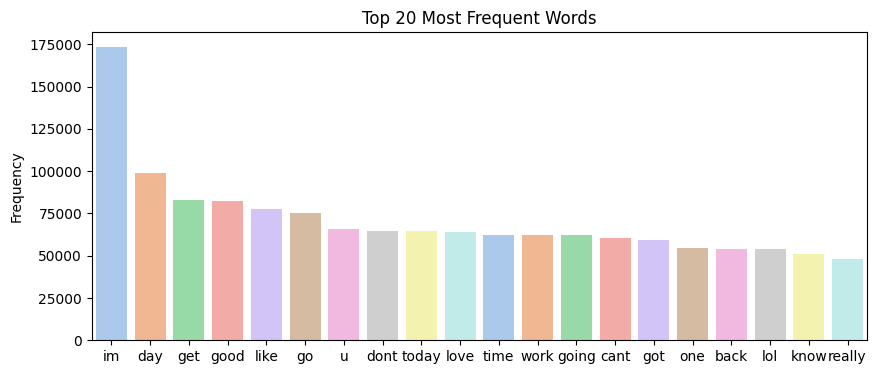

In [ ]:
all_words = ' '.join(data['clean_text']).split() # Menggabungkan seluruh teks bersih menjadi satu string besar dan memecahnya menjadi daftar kata
top_words = Counter(all_words).most_common(20) # Menghitung frekuensi kemunculan setiap kata dan mengambil 20 kata teratas yg paling sering muncul
words, counts = zip(*top_words) # Memisahkan kata dan jumlah kemunculannya menjadi dua variabel terpisah
plt.figure(figsize=(10,4))
sns.barplot(x=list(words), y=list(counts), palette='pastel')
plt.xticks()
plt.title('Top 20 Most Frequent Words')
plt.ylabel('Frequency')
plt.show()

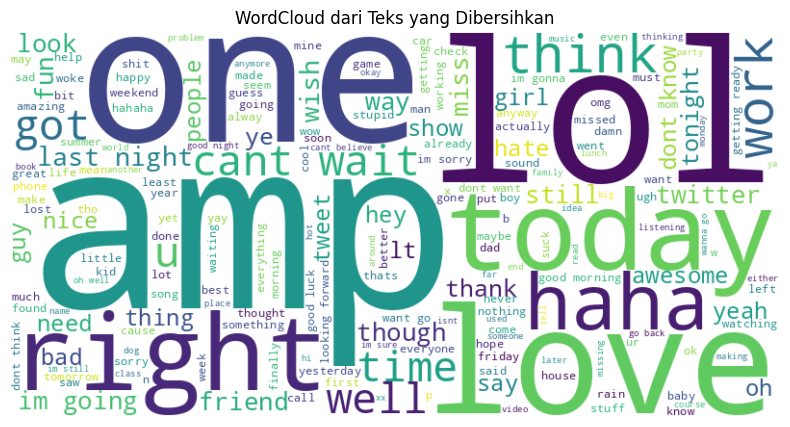

In [ ]:
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    stopwords=STOPWORDS
).generate(' '.join(all_words))  # Menghasilkan word cloud dari gabungan semua kata yg udah dibersihkan
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') # Menghilangkan sumbu agar tampilan lebih bersih
plt.title('WordCloud dari Teks yang Dibersihkan')
plt.show()

In [ ]:
# Mengambil kolom clean_text sebagai fitur (X) dan kolom target sebagai label (y)
X_text = data['clean_text']
y = data['target'].values


# Membagi dataset menjadi data latih dan data uji dgn perbandingan 80:20
X_train_text, X_test_text, y_train_nb, y_test_nb = train_test_split(
    X_text, y, test_size=0.2, stratify=y, random_state=42 # Random state disetel untuk memastikan pembagian data yg konsisten dan dapat direproduksi
)

In [ ]:
overlap_cleaned = set(X_train_text).intersection(set(X_test_text)) # Mencari irisan antara data teks yg udh dibersihkan pada data latih dan data uji
print(f"Overlap (cleaned_text) between train and test: {len(overlap_cleaned)}") # Menampilkan jumlah data teks yg sama muncul

Overlap (cleaned_text) between train and test: 0


In [ ]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1, 2)) # Membuat TF-IDF vectorizer dgn maksimum 5000 fitur dan n-gram 1 sampai 2 kata

X_train_tfidf = tfidf.fit_transform(X_train_text) # Melakukan fitting dan transformasi pada data latih
X_test_tfidf = tfidf.transform(X_test_text) # Melakukan transformasi pada data uji menggunakan model TF-IDF yg udh dilatih

param_grid = {'alpha': [0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0]} # Mendefinisikan grid parameter untuk pencarian nilai alpha terbai
nb = MultinomialNB() # Membuat objek Multinomial Naive Bayes

# Melakukan GridSearch dgn 5-fold cross-validation untuk mencari alpha terbaik berdasarkan akurasi
grid_search = GridSearchCV(nb, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tfidf, y_train_nb)


# Mengambil nilai alpha terbaik dan skor cross-validation terbaik dari hasil GridSearch
best_alpha = grid_search.best_params_['alpha']
best_score = grid_search.best_score_

print(f"Best alpha from GridSearchCV: {best_alpha}")
print(f"Best cross-validation accuracy: {best_score:.4f}")


# Melatih model Naive Bayes dgn parameter alpha terbaik
nb_best = MultinomialNB(alpha=best_alpha)
nb_best.fit(X_train_tfidf, y_train_nb)
y_pred_nb = nb_best.predict(X_test_tfidf) # Melakukan prediksi pada data uji

test_accuracy = accuracy_score(y_test_nb, y_pred_nb)
print(f"Test accuracy: {test_accuracy:.4f}")
print("\n=== Naive Bayes Classification Report ===")
print(classification_report(y_test_nb, y_pred_nb, target_names=['Negative', 'Positive']))

Best alpha from GridSearchCV: 2.0
Best cross-validation accuracy: 0.7553
Test accuracy: 0.7573

=== Naive Bayes Classification Report ===
              precision    recall  f1-score   support

    Negative       0.76      0.77      0.76    149638
    Positive       0.76      0.75      0.75    146500

    accuracy                           0.76    296138
   macro avg       0.76      0.76      0.76    296138
weighted avg       0.76      0.76      0.76    296138



In [ ]:
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>') # Membuat tokenizer dgn maksimal 20.000 kata dan token khusus untuk kata di luar kosa kata (OOV)
tokenizer.fit_on_texts(data['clean_text']) # Melatih tokenizer berdasarkan teks yg udh dibersihkan
sequences = tokenizer.texts_to_sequences(data['clean_text']) # Mengonversi teks menjadi urutan indeks kata
padded_sequences = pad_sequences(sequences, maxlen=50, padding='post') # Melakukan padding pada urutan agar panjangnya seragam (maxlen=50),dgn penambahan padding di akhir

embedding_model = api.load("glove-wiki-gigaword-100") # Memuat model embedding pretrained GloVe dgn dimensi 100
embedding_dim = 100
embedding_matrix = np.zeros((20000, embedding_dim)) # Membuat matriks embedding dgn ukuran (20000 kata x 100 dimensi)
for word, i in tokenizer.word_index.items(): # Mengisi matriks embedding dgn vektor dari pretrained model untuk kata yg ada dalam vocabulary tokenizer
    if i < 20000 and word in embedding_model.key_to_index:
        embedding_matrix[i] = embedding_model[word]

# Membagi data menjadi data latih dan data uji dgn proporsi 80:20, stratifikasi untuk menjaga distribusi label
X_train, X_test, y_train, y_test = train_test_split(
    padded_sequences, y, test_size=0.2, stratify=y, random_state=42
)

# Mendefinisikan class weights untuk mengatasi ketidakseimbangan kelas
class_weights = {0:1.0, 1:1.0}

model = Sequential([
    Input(shape=(50,)), # Input layer sesuai panjang urutan 50
    Embedding(input_dim=20000, output_dim=embedding_dim, weights=[embedding_matrix], trainable=True), # Embedding layer menggunakan matriks embedding pretrained, dapat di-train ulang
    SpatialDropout1D(0.3), # SpatialDropout1D untuk regularisasi
    Bidirectional(LSTM(128, return_sequences=True)),
    Bidirectional(LSTM(64)), # Dua lapisan Bidirectional LSTM berturut-turut (128 unit dan 64 unit)
    Dropout(0.3), # Dropout untuk regularisasi
    Dense(2, activation='softmax') # Dense layer output dgn 2 unit dan aktivasi softmax untuk klasifikasi dua kelas
])


# Menampilkan ringkasan arsitektur model
model.summary()

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy']) # Menyusun model dgn fungsi loss sparse categorical crossentropy dan optimizer Adam
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # Menyiapkan callback EarlyStopping untuk menghentikan pelatihan jika val_loss tidak membaik selama 3 epoch dan mengembalikan bobot terbaik
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-5, verbose=1) # Menyiapkan callback ReduceLROnPlateau untuk mengurangi learning rate jika val_loss stagnan selama 2 epoch


# Melatih model dgn batch size 64 selama maksimal 5 epoch, menggunakan 10% data latih sebagai validasi
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    class_weight=class_weights,
    verbose=1
)

# Melakukan prediksi kelas pada data uji dan mengambil kelas dgn probabilitas tertinggi
y_pred_lstm = np.argmax(model.predict(X_test), axis=1)

# Menghitung akurasi prediksi pada data uji
lstm_accuracy = accuracy_score(y_test, y_pred_lstm)
print(f"Akurasi di data uji LSTM: {lstm_accuracy:.4f}")

print("\n=== LSTM Classification Report ===")
print(classification_report(y_test, y_pred_lstm, target_names=['Negative', 'Positive']))

[==================================================] 100.0% 128.1/128.1MB downloaded


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 50, 100)        │     2,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout1d               │ (None, 50, 100)        │             0 │
│ (SpatialDropout1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 50, 256)        │       234,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │       164,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,399,106 (9.15 MB)

 Trainable params: 2,399,106 (9.15 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
16658/16658 ━━━━━━━━━━━━━━━━━━━━ 7186s 431ms/step - accuracy: 0.7552 - loss: 0.4987 - val_accuracy: 0.7922 - val_loss: 0.4424 - learning_rate: 0.0010
Epoch 2/5
16658/16658 ━━━━━━━━━━━━━━━━━━━━ 7332s 437ms/step - accuracy: 0.7945 - loss: 0.4404 - val_accuracy: 0.7967 - val_loss: 0.4363 - learning_rate: 0.0010
Epoch 3/5
16658/16658 ━━━━━━━━━━━━━━━━━━━━ 7144s 429ms/step - accuracy: 0.8037 - loss: 0.4246 - val_accuracy: 0.7985 - val_loss: 0.4352 - learning_rate: 0.0010
Epoch 4/5
16658/16658 ━━━━━━━━━━━━━━━━━━━━ 7091s 426ms/step - accuracy: 0.8105 - loss: 0.4126 - val_accuracy: 0.7987 - val_loss: 0.4388 - learning_rate: 0.0010
Epoch 5/5
16658/16658 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step - accuracy: 0.8162 - loss: 0.4027
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
16658/16658 ━━━━━━━━━━━━━━━━━━━━ 7238s 434ms/step - accuracy: 0.8162 - loss: 0.4027 - val_accuracy: 0.7981 - val_loss: 0.4412 - learning_rate: 0.0010
9255/9255 ━━━━━━━━━━━━━━━━━━━━ 806s 87ms/st

In [ ]:
def plot_classification_report(y_true, y_pred, model_name):
    report = classification_report(y_true, y_pred, target_names=['Negative', 'Positive'], output_dict=True) # Menghasilkan classification report dalam format dictionary dgn label kelas 'Negative' dan 'Positive'
    metrics = ['precision', 'recall', 'f1-score'] # Mendefinisikan metrik yg akan diplot: precision, recall, dan f1-score
    scores = [np.mean([report[label][m] for label in ['Negative', 'Positive']]) for m in metrics] # Menghitung rata-rata nilai metrik untuk kedua kelas (Negative dan Positive)
    plt.bar(metrics, scores, color='skyblue')
    plt.ylim(0,1) # Mengatur batas sumbu y antara 0 dan 1
    plt.title(f'{model_name} Metrics')
    plt.ylabel('Score')
    for i, score in enumerate(scores): # Menampilkan nilai skor di atas masing-masing batang grafik untuk kejelasan
        plt.text(i, score + 0.02, f'{score:.2f}', ha='center')
    plt.show()

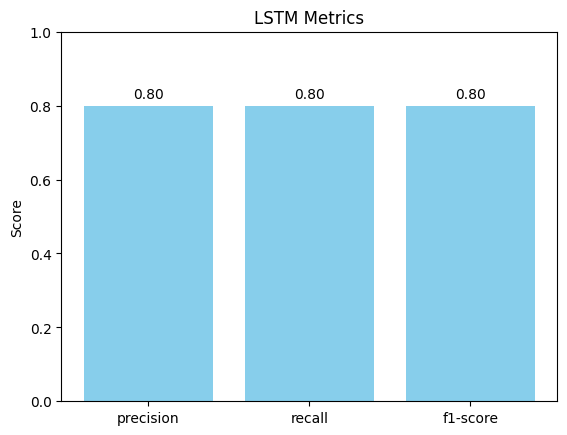

In [ ]:
plot_classification_report(y_test, y_pred_lstm, 'LSTM')

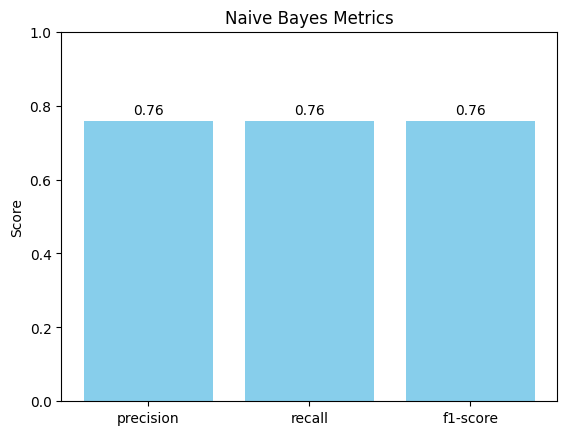

In [ ]:
plot_classification_report(y_test_nb, y_pred_nb, 'Naive Bayes')

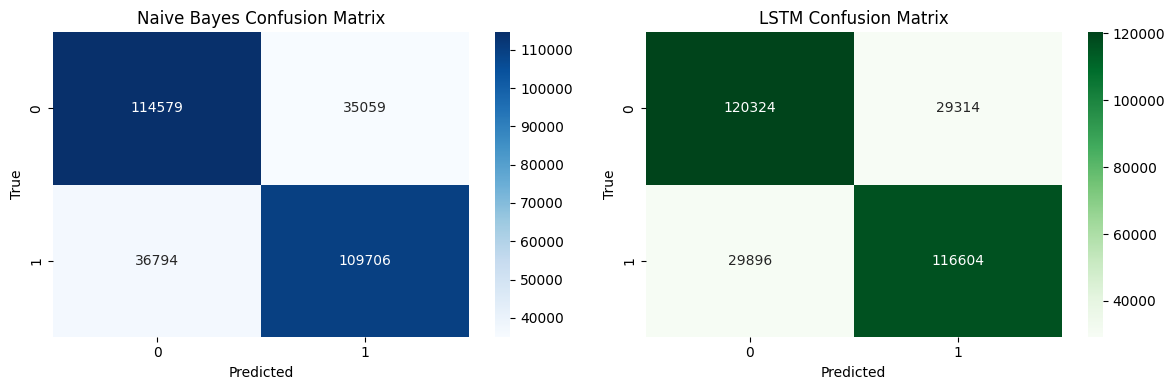

In [ ]:
# Membuat confusion matrix untuk hasil prediksi model Naive Bayes dan LSTM
nb_cm = confusion_matrix(y_test_nb, y_pred_nb)
lstm_cm = confusion_matrix(y_test, y_pred_lstm)

# Plot confusion matrix untuk Naive Bayes di subplot pertama (1 baris, 2 kolom, posisi 1)
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.heatmap(nb_cm, annot=True, fmt='d', cmap='Blues')
plt.title('Naive Bayes Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# Plot confusion matrix untuk LSTM di subplot kedua (1 baris, 2 kolom, posisi 2)
plt.subplot(1,2,2)
sns.heatmap(lstm_cm, annot=True, fmt='d', cmap='Greens')
plt.title('LSTM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout() # AGar tidak tumpang tindih
plt.show()

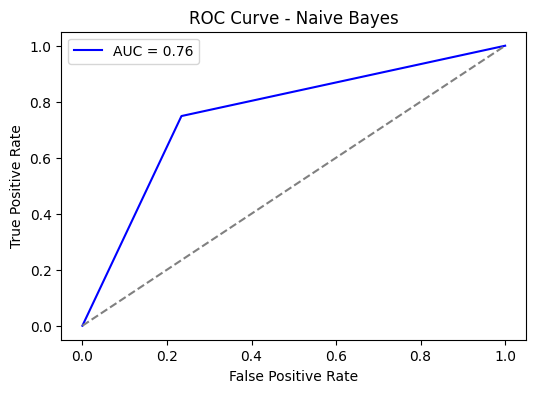

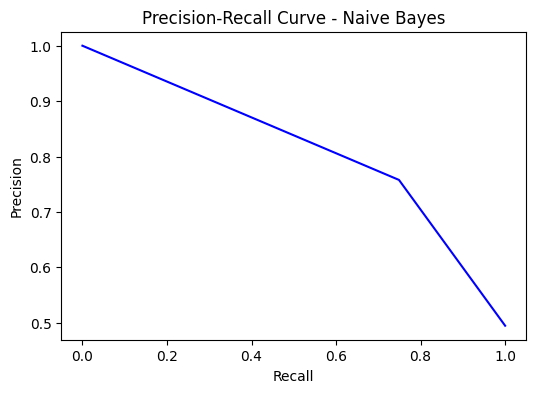

In [ ]:
# Menghitung False Positive Rate (FPR), True Positive Rate (TPR), dan threshold untuk ROC Curve
fpr_nb, tpr_nb, _ = roc_curve(y_test_nb, y_pred_nb)
roc_auc_nb = auc(fpr_nb, tpr_nb) # Menghitung Area Under the Curve (AUC) dari ROC Curve
plt.figure(figsize=(6,4))
plt.plot(fpr_nb, tpr_nb, color='blue', label=f'AUC = {roc_auc_nb:.2f}')   # Plot kurva ROC dgn nilai AUC
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Naive Bayes')
plt.legend()
plt.show()

precision_nb, recall_nb, _ = precision_recall_curve(y_test_nb, y_pred_nb) # Menghitung precision, recall, dan threshold untuk Precision-Recall Curve model NB
plt.figure(figsize=(6,4))
plt.plot(recall_nb, precision_nb, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Naive Bayes')
plt.show()

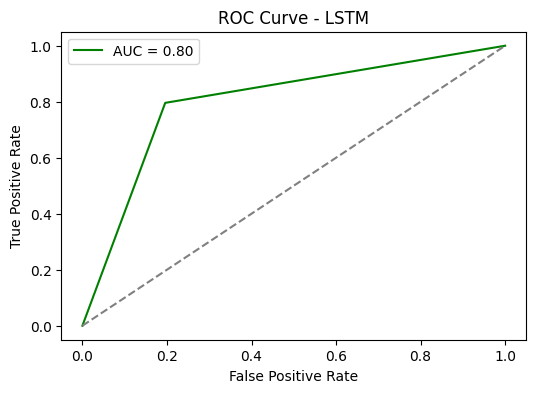

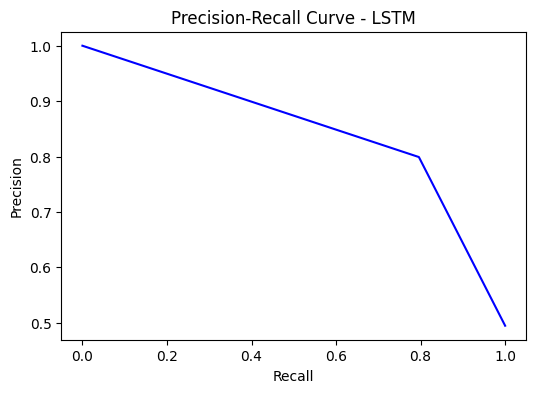

In [ ]:
# Menghitung False Positive Rate (FPR), True Positive Rate (TPR), dan threshold untuk ROC Curve model LSTM
fpr_lstm, tpr_lstm, _ = roc_curve(y_test, y_pred_lstm)
roc_auc_lstm = auc(fpr_lstm, tpr_lstm)
plt.figure(figsize=(6,4))
plt.plot(fpr_lstm, tpr_lstm, color='green', label=f'AUC = {roc_auc_lstm:.2f}')
plt.plot([0,1], [0,1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM')
plt.legend()
plt.show()

precision, recall, _ = precision_recall_curve(y_test, y_pred_lstm) # Menghitung precision, recall, dan threshold untuk Precision-Recall Curve model LSTM
plt.figure(figsize=(6,4))
plt.plot(recall, precision, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - LSTM')
plt.show()

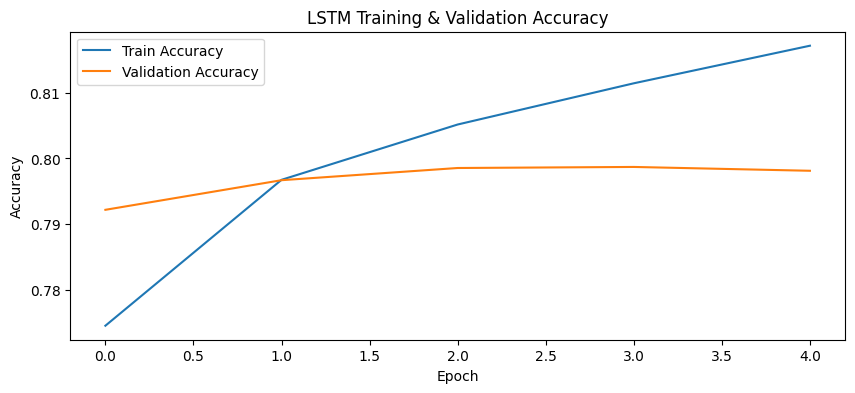

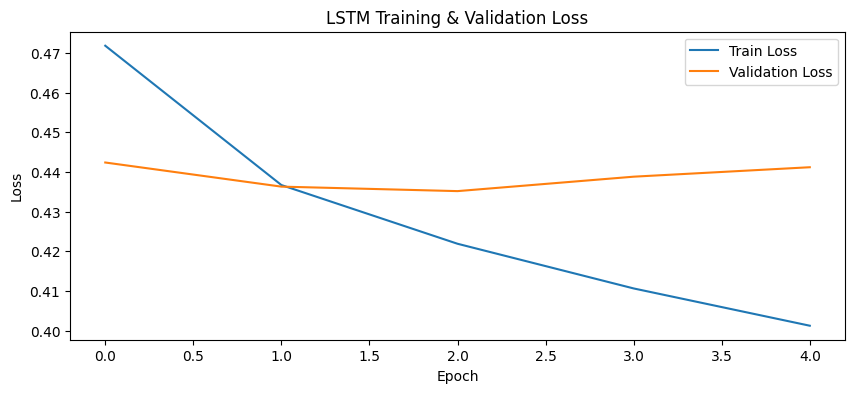

In [ ]:
# Membuat plot akurasi training dan validasi dari model LSTM per epoch
plt.figure(figsize=(10,4))
plt.plot(history.history['accuracy'], label='Train Accuracy') # Akurasi pada data training
plt.plot(history.history['val_accuracy'], label='Validation Accuracy') # Akurasi pada data validasi
plt.title('LSTM Training & Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Membuat plot loss training dan validasi dari model LSTM per epoch
plt.figure(figsize=(10,4))
plt.plot(history.history['loss'], label='Train Loss') # Loss pada data training
plt.plot(history.history['val_loss'], label='Validation Loss') # Loss pada data validasi
plt.title('LSTM Training & Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
